In [13]:
pip install tinyec

In [2]:
pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00


In [14]:
pip install qrcode

**Kode untuk mengenerate sepasang kunci ECC**

In [16]:
# Import library tinyec
from tinyec import registry
import secrets

# Fungsi untuk mengenerate sepasang kunci ECC dengan nama kurva eliptik sebagai argumen
def generate_ecc_keys(curve_name):
  # Dapatkan objek kurva eliptik dari registry berdasarkan nama kurva eliptik
  curve = registry.get_curve(curve_name)
  # Buat kunci privat ECC secara acak
  private_key = secrets.randbelow(curve.field.n)
  # Buat kunci publik ECC dengan mengalikan kunci privat dengan generator point
  public_key = private_key * curve.g
  # Kembalikan kunci publik dan privat ECC
  return public_key, private_key

# Contoh penggunaan fungsi di atas
# Pilih nama kurva eliptik yang diinginkan, misalnya brainpoolP256r1
curve_name = "brainpoolP256r1"
# Buat sepasang kunci ECC dengan nama kurva eliptik tersebut
public_key, private_key = generate_ecc_keys(curve_name)
# Cetak kunci ECC dalam bentuk heksadesimal
print("Public key:", public_key.x.to_bytes(32, 'big').hex() + public_key.y.to_bytes(32, 'big').hex())
print("Private key:", private_key.to_bytes(32, 'big').hex())


Public key: 24dc0fb004b9d4d076ced6205e4241ae13ffeac2d582d3ec32acb8b0bd62cb2f2bde155d614412f7dfe58a42c23c89427cdd2d74bf9526c32eb0fa6db1ca6e85
Private key: 964da640f9afdbaa6af7da558d59eeb751543475130da18ffeb63ab1a09f2682


**Kode untuk melakukan Enkripsi dengan ECC**

In [13]:
# Import library tinyec dan pycryptodome
from tinyec import registry
from Crypto.Cipher import AES
from Crypto.Hash import SHA256
import secrets
from tinyec import ec

# Fungsi untuk mengubah string menjadi objek point
def string_to_point(string, curve_name):
  # Pisahkan string menjadi dua bagian yang sama panjang
  half = len(string) // 2
  x_string = string[:half]
  y_string = string[half:]
  # Ubah x dan y dari heksadesimal menjadi integer
  x = int(x_string, 16)
  y = int(y_string, 16)
  # Dapatkan objek kurva eliptik dari registry
  curve = registry.get_curve(curve_name)
  # Buat objek point dengan kurva, x, dan y
  point = ec.Point(curve, x, y)
  # Kembalikan objek point
  return point

# Fungsi untuk mengubah string menjadi integer
def string_to_integer(string):
  # Ubah string dari heksadesimal menjadi integer
  integer = int(string, 16)
  # Kembalikan integer
  return integer

# Tambahan
# Fungsi untuk mengubah string public key, string private key, dan curve name menjadi kunci publik dan kunci privat ECC
def get_ecc_public_key(public_key_string,curve_name):
  # Ubah string public key menjadi objek point
  public_key = string_to_point(public_key_string, curve_name)
  # Kembalikan kunci publik ECC
  return public_key

# Fungsi untuk mengenkripsi pesan dengan kunci publik ECC
def encrypt_ecc(message, public_key):
  # Pilih kurva eliptik yang sama dengan kunci publik
  curve = registry.get_curve(public_key.curve.name)
  # Buat kunci privat sementara (ephemeral) secara acak
  ephemeral_private_key = secrets.randbelow(curve.field.n)
  # Buat kunci publik sementara dengan mengalikan kunci privat sementara dengan generator point
  ephemeral_public_key = ephemeral_private_key * curve.g
  # Hitung kunci ECC yang dibagi dengan mengalikan kunci publik ECC dengan kunci privat sementara
  shared_ecc_key = ephemeral_private_key * public_key
  # Ubah kunci ECC yang dibagi menjadi kunci AES dengan menggunakan fungsi hash SHA256
  shared_aes_key = SHA256.new(shared_ecc_key.x.to_bytes(32, 'big')).digest()
  # Buat objek AES dengan mode GCM (Galois Counter Mode) yang mendukung autentikasi
  aes = AES.new(shared_aes_key, AES.MODE_GCM)
  # Enkripsi pesan dengan AES dan dapatkan ciphertext dan tag autentikasi
  ciphertext, tag = aes.encrypt_and_digest(message.encode('utf-8'))
  # Kembalikan ciphertext, tag, nonce, dan kunci publik sementara
  return ciphertext, tag, aes.nonce, ephemeral_public_key

# Berikan string public key, string private key, dan nama kurva eliptik yang Anda gunakan
public_key_string = "2a40d80e739f163bde8f2bd471a637f9ec6f17cf0e78fe497c7ea40d90e84b62955ce37843a0c7a5e10a630c4d2e1e8199c9c15d208cfa4d4692298818510e68"
curve_name = "brainpoolP256r1"
# Ubah string menjadi kunci publik dan kunci privat ECC
public_key = get_ecc_public_key(public_key_string, curve_name)
# Buat pesan yang ingin dikirim
message = "bf33c3a6cca740fb8aabb1f9c8f3a1e2871d75f0a3e7e3027857963610d3f652"
# Enkripsi pesan dengan kunci publik ECC
ciphertext, tag, nonce, ephemeral_public_key = encrypt_ecc(message, public_key)
# Cetak ciphertext dan kunci publik sementara dalam bentuk heksadesimal
print("Ciphertext:", ciphertext.hex())


Ciphertext: ce6ae1ce2312786b7ae6eb7aea0ff735b379236c4847f00094082ac0ab275e843104116ab79f46b0ed6674aeece8cc935cb9d2259f50d62904d0b0abee56741f


**Kode untuk melakukan dekrip dari chipertext yang dibuat oleh lembar kode enkripsi sebelumnya**

In [58]:
# Import library tinyec dan pycryptodome
from tinyec import registry
from Crypto.Cipher import AES
from Crypto.Hash import SHA256
import secrets
from tinyec import ec

# Fungsi untuk mengubah string menjadi objek point
def string_to_point(string, curve_name):
  # Pisahkan string menjadi dua bagian yang sama panjang
  half = len(string) // 2
  x_string = string[:half]
  y_string = string[half:]
  # Ubah x dan y dari heksadesimal menjadi integer
  x = int(x_string, 16)
  y = int(y_string, 16)
  # Dapatkan objek kurva eliptik dari registry
  curve = registry.get_curve(curve_name)
  # Buat objek point dengan kurva, x, dan y
  point = ec.Point(curve, x, y)
  # Kembalikan objek point
  return point

# Fungsi untuk mengubah string menjadi integer
def string_to_integer(string):
  # Ubah string dari heksadesimal menjadi integer
  integer = int(string, 16)
  # Kembalikan integer
  return integer

# Fungsi untuk mengubah string public key, string private key, dan curve name menjadi kunci publik dan kunci privat ECC
def get_ecc_private_key(private_key_string, curve_name):
  # Ubah string private key menjadi integer
  private_key = string_to_integer(private_key_string)
  # Kembalikan kunci publik dan privat ECC
  return private_key

# Fungsi untuk mendekripsi pesan dengan kunci privat ECC
def decrypt_ecc(ciphertext, tag, nonce, ephemeral_public_key, private_key):
  # Hitung kunci ECC yang dibagi dengan mengalikan kunci publik sementara dengan kunci privat ECC
  shared_ecc_key = private_key * ephemeral_public_key
  # Ubah kunci ECC yang dibagi menjadi kunci AES dengan menggunakan fungsi hash SHA256
  shared_aes_key = SHA256.new(shared_ecc_key.x.to_bytes(32, 'big')).digest()
  # Buat objek AES dengan mode GCM dan nonce yang diberikan
  aes = AES.new(shared_aes_key, AES.MODE_GCM, nonce=nonce)
  # Dekripsi ciphertext dengan AES dan verifikasi tag autentikasi
  message = aes.decrypt_and_verify(ciphertext, tag).decode('utf-8')
  # Kembalikan pesan yang didekripsi
  return message

# Contoh penggunaan fungsi-fungsi di atas
# Berikan string public key, nama kurva eliptik yang Anda gunakan
private_key_string = "0fa1e98f25425693110756477ae706bc19c5d7a3d27dc2618da8b5eb8e7f5e40"
curve_name = "brainpoolP256r1"
# Ubah string menjadi kunci publik dan kunci privat ECC
private_key = get_ecc_private_key(private_key_string, curve_name)
# Baris ini memerlukan informasi tag, nonce dan ephemeral_public_key pada proses enkripsi sebelumnya, yang tersimpan di memori
coba = "159b22f1759cfcb7923a0a13eb81b0c50f6f19368eda0c545cfa85a982de6a78e853742670a0105658db80b86f18dfcd459d2a71fe8aa484a269daeb70a19f2a"
# Dekripsi pesan dengan kunci privat ECC
decrypted_message = decrypt_ecc(ciphertext, tag, nonce, ephemeral_public_key, private_key)
# Cetak pesan yang didekripsi
print("Decrypted message:", decrypted_message)
print(ciphertext)


Decrypted message: e6da202a9cf706076c5097f9688fe33f652ac5447e298a18318cac9b6d4c3d96
b'\x15\x9b"\xf1u\x9c\xfc\xb7\x92:\n\x13\xeb\x81\xb0\xc5\x0fo\x196\x8e\xda\x0cT\\\xfa\x85\xa9\x82\xdejx\xe8St&p\xa0\x10VX\xdb\x80\xb8o\x18\xdf\xcdE\x9d*q\xfe\x8a\xa4\x84\xa2i\xda\xebp\xa1\x9f*'


**Kode Server untuk build label produk (Qrcode)**

hash: e6da202a9cf706076c5097f9688fe33f652ac5447e298a18318cac9b6d4c3d96
Ciphertext: d6bb3afa501398ab957ad0638b918ba47009649b05e42f872dfdb9a03f97019cf10e084b0f2d46f8e99fa7278bb43b0a96556d844f5a824ee1663029b4fc1a80
tag: 024eaf14426d6cbc510b2a6bd3426fdb
nonce: 92c4f1842072b13923ef649415d95f49
ephemeral_public_key_string: 6588bb827ec6095dd0440d2ea31aeaec448e45da351e014346d4a47f247c5db39f315c52483e3a626861ce8ba2f072040668a4b3e9c7785b5f64a2a618640be8


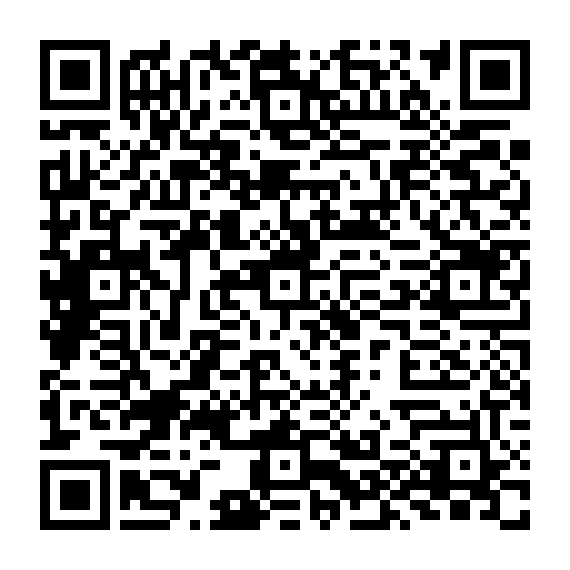

In [23]:
# Import library tinyec dan pycryptodome
from tinyec import registry
from Crypto.Cipher import AES
from Crypto.Hash import SHA256
from Crypto.PublicKey import ECC
import secrets
from tinyec import ec
import qrcode

# Fungsi untuk mengubah string menjadi objek point
def string_to_point(string, curve_name):
  # Pisahkan string menjadi dua bagian yang sama panjang
  half = len(string) // 2
  x_string = string[:half]
  y_string = string[half:]
  # Ubah x dan y dari heksadesimal menjadi integer
  x = int(x_string, 16)
  y = int(y_string, 16)
  # Dapatkan objek kurva eliptik dari registry
  curve = registry.get_curve(curve_name)
  # Buat objek point dengan kurva, x, dan y
  point = ec.Point(curve, x, y)
  # Kembalikan objek point
  return point

# Fungsi untuk mengubah string menjadi integer
def string_to_integer(string):
  # Ubah string dari heksadesimal menjadi integer
  integer = int(string, 16)
  # Kembalikan integer
  return integer

# Tambahan
# Fungsi untuk mengubah string public key, string private key, dan curve name menjadi kunci publik dan kunci privat ECC
def get_ecc_public_key(public_key_string,curve_name):
  # Ubah string public key menjadi objek point
  public_key = string_to_point(public_key_string, curve_name)
  # Kembalikan kunci publik ECC
  return public_key

# Fungsi untuk mengenkripsi pesan dengan kunci publik ECC
def encrypt_ecc(message, public_key):
  # Pilih kurva eliptik yang sama dengan kunci publik
  curve = registry.get_curve(public_key.curve.name)
  # Buat kunci privat sementara (ephemeral) secara acak
  ephemeral_private_key = secrets.randbelow(curve.field.n)
  # Buat kunci publik sementara dengan mengalikan kunci privat sementara dengan generator point
  ephemeral_public_key = ephemeral_private_key * curve.g
  # Hitung kunci ECC yang dibagi dengan mengalikan kunci publik ECC dengan kunci privat sementara
  shared_ecc_key = ephemeral_private_key * public_key
  # Ubah kunci ECC yang dibagi menjadi kunci AES dengan menggunakan fungsi hash SHA256
  shared_aes_key = SHA256.new(shared_ecc_key.x.to_bytes(32, 'big')).digest()
  # Buat objek AES dengan mode GCM (Galois Counter Mode) yang mendukung autentikasi
  aes = AES.new(shared_aes_key, AES.MODE_GCM)
  # Enkripsi pesan dengan AES dan dapatkan ciphertext dan tag autentikasi
  ciphertext, tag = aes.encrypt_and_digest(message.encode('utf-8'))
  # Kembalikan ciphertext, tag, nonce, dan kunci publik sementara
  return ciphertext, tag, aes.nonce, ephemeral_public_key

# Fungsi untuk melakukan hash terhadap data
def hash_sha256_string(string):
  # Membuat string yang ingin di-hash
  string_to_hash = string
  # Membuat objek hash SHA256
  hash_object = hashlib.sha256()
  # Menambahkan data string ke objek hash
  hash_object.update(string_to_hash.encode())
  # Mendapatkan nilai hash dalam format heksadesimal
  hex_digest = hash_object.hexdigest()
  # Mengembalikasn nilai hash
  return hex_digest

def hash_string(text):
  # Membuat objek hash baru
  hash_object = SHA256.new()
  # Menambahkan data yang ingin di-hash
  hash_object.update(text.encode())
  # Mendapatkan hasil hash dalam bentuk heksadesimal
  hash_result = hash_object.hexdigest()
  # Mengembalikan hasil hash
  return hash_result

def encode_to_qrcode(string):
  # Membuat objek qrcode
  qr = qrcode.QRCode()
  # Menambahkan data ke objek qrcode
  qr.add_data(string)
  # Membuat qrcode
  img = qr.make_image()
  # Menyimpan qrcode sebagai gambar PNG
  img.save("qrcode.png")
  # Menampilkan gambar qrcode
  return img

# Berikan string public key, string private key, dan nama kurva eliptik yang Anda gunakan
public_key_string = "2a40d80e739f163bde8f2bd471a637f9ec6f17cf0e78fe497c7ea40d90e84b62955ce37843a0c7a5e10a630c4d2e1e8199c9c15d208cfa4d4692298818510e68"
curve_name = "brainpoolP256r1"
# Ubah string menjadi kunci publik dan kunci privat ECC
public_key = get_ecc_public_key(public_key_string, curve_name)
# Buat pesan yang ingin dikirim
message = '{"nzmzm":"ini percobaan bro"}'
message_hash_sha256 = hash_string(message)
# Enkripsi pesan dengan kunci publik ECC
ciphertext, tag, nonce, ephemeral_public_key = encrypt_ecc(message_hash_sha256, public_key)
# Enkode chipertext ke qrcode
qrcode_chipertext = encode_to_qrcode(ciphertext.hex())

# Menyimpan ephemeral_public_key_string ke file
with open("tag.txt", "w") as f:
  f.write(tag.hex())

# Menyimpan ephemeral_public_key_string ke file
with open("nonce.txt", "w") as f:
  f.write(nonce.hex())

# Mengubah ephemeral_public_key menjadi string
#ephemeral_public_key_string = str(ephemeral_public_key)
#ephemeral_public_key_string = ephemeral_public_key.to_string('hex')
ephemeral_public_key_string = '%x%x' % (ephemeral_public_key.x, ephemeral_public_key.y)

# Menyimpan ephemeral_public_key_string ke file
with open("ephemeral_public_key.txt", "w") as f:
  f.write(ephemeral_public_key_string)

# Cetak ciphertext, hash, tag, nonce dan ephemeral_public_key_string
print("hash:",message_hash_sha256)
print("Ciphertext:", ciphertext.hex())
print("tag:", tag.hex())
print("nonce:", nonce.hex())
print("ephemeral_public_key_string:", ephemeral_public_key_string)
qrcode_chipertext


In [ ]:
# Import library tinyec
from tinyec import registry

# Fungsi untuk menampilkan semua atribut dari tinyec.registry
def show_registry_attributes():
  # Dapatkan list nama atribut dari tinyec.registry
  attributes = dir(curve)
  # Cetak list nama atribut
  print("List nama atribut dari tinyec.registry:")
  for attribute in attributes:
    print(attribute)

# Contoh penggunaan fungsi di atas
show_registry_attributes()


**Kode di sisi client dari protokol traceability**

In [26]:
# Import library tinyec dan pycryptodome
from tinyec import registry
from Crypto.Cipher import AES
from Crypto.Hash import SHA256
import secrets
from tinyec import ec
import cv2

# Fungsi untuk mengubah string menjadi objek point
def string_to_point(string, curve_name):
  # Pisahkan string menjadi dua bagian yang sama panjang
  half = len(string) // 2
  x_string = string[:half]
  y_string = string[half:]
  # Ubah x dan y dari heksadesimal menjadi integer
  x = int(x_string, 16)
  y = int(y_string, 16)
  # Dapatkan objek kurva eliptik dari registry
  curve = registry.get_curve(curve_name)
  # Buat objek point dengan kurva, x, dan y
  point = ec.Point(curve, x, y)
  # Kembalikan objek point
  return point

# Fungsi untuk mengubah string menjadi integer
def string_to_integer(string):
  # Ubah string dari heksadesimal menjadi integer
  integer = int(string, 16)
  # Kembalikan integer
  return integer

# Fungsi untuk mengubah string public key, string private key, dan curve name menjadi kunci publik dan kunci privat ECC
def get_ecc_private_key(private_key_string, curve_name):
  # Ubah string private key menjadi integer
  private_key = string_to_integer(private_key_string)
  # Kembalikan kunci publik dan privat ECC
  return private_key

# Fungsi untuk mendekripsi pesan dengan kunci privat ECC
def decrypt_ecc(ciphertext, tag, nonce, ephemeral_public_key, private_key):
  # Hitung kunci ECC yang dibagi dengan mengalikan kunci publik sementara dengan kunci privat ECC
  shared_ecc_key = private_key * ephemeral_public_key
  # Ubah kunci ECC yang dibagi menjadi kunci AES dengan menggunakan fungsi hash SHA256
  shared_aes_key = SHA256.new(shared_ecc_key.x.to_bytes(32, 'big')).digest()
  # Buat objek AES dengan mode GCM dan nonce yang diberikan
  aes = AES.new(shared_aes_key, AES.MODE_GCM, nonce=nonce)
  # Dekripsi ciphertext dengan AES dan verifikasi tag autentikasi
  message = aes.decrypt_and_verify(ciphertext, tag).decode('utf-8')
  # Kembalikan pesan yang didekripsi
  return message

# Fungsi untuk mendekode qrcode label produk
def decode_qrcode(qrcode_img_png):
  # Load the QR code image
  img = cv2.imread(qrcode_img_png)
  # Convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Create a QR code detector
  detector = cv2.QRCodeDetector()
  # Detect and decode the QR code
  data, bbox, _ = detector.detectAndDecode(gray)
  # Print the decoded data
  if data:
    return data
  else:
    return "No QR code found"

# dekode qrcode
qrcode_img_png = "qrcode.png"
qrcode_string = decode_qrcode(qrcode_img_png)

# Berikan string public key, nama kurva eliptik yang Anda gunakan
private_key_string = "0fa1e98f25425693110756477ae706bc19c5d7a3d27dc2618da8b5eb8e7f5e40"
curve_name = "brainpoolP256r1"

# Ubah string menjadi kunci publik dan kunci privat ECC
private_key = get_ecc_private_key(private_key_string, curve_name)

message = bytes.fromhex(qrcode_string)
# Baris ini memerlukan informasi tag, nonce dan ephemeral_public_key pada proses enkripsi sebelumnya, yang tersimpan di memori
# Dekripsi pesan dengan kunci privat ECC, dengan syarat tag, nonce dan ephemeral_public_key berasal dari server, untuk demo ini ketiganya disederhanakan tanpa harus unduh dari server, asalkan proses demo enkrip dan dekrip dalam komputer yang sama dan sesi google colab yang sama

# Membaca string hex yang berisi tag dari file
with open("tag.txt", "r") as f:
  tag_hex = f.read()

# Membaca string hex yang berisi nonce dari file
with open("nonce.txt", "r") as f:
  nonce_hex = f.read()

# Membaca string hex yang berisi ephemeral_public_key dari file
with open("ephemeral_public_key.txt", "r") as f:
  ephemeral_public_key_string = f.read()

# Mengubah string hex yang berisi tag dan nonce menjadi bertipe bytes
tag = bytes.fromhex(tag_hex)
nonce = bytes.fromhex(nonce_hex)

# Mengubah string hex yang berisi ephemeral_public_key menjadi objek poin
# Mengubah string yang berisi ephemeral_public_key menjadi objek poin
curve = registry.get_curve('brainpoolP256r1')
# Mengubah string hex yang berisi ephemeral_public_key menjadi objek poin
curve = registry.get_curve('brainpoolP256r1')
half = len(ephemeral_public_key_string) // 2
ephemeral_public_key_x = int(ephemeral_public_key_string[:half], 16)
ephemeral_public_key_y = int(ephemeral_public_key_string[half:], 16)
ephemeral_public_key = Point(curve, ephemeral_public_key_x, ephemeral_public_key_y)
#ephemeral_public_key = ec.Point(curve, ephemeral_public_key_string)

#ephemeral_public_key = ECC.import_key(bytes.fromhex(ephemeral_public_key_hex))

decrypted_message = decrypt_ecc(message, tag, nonce, ephemeral_public_key, private_key)

# Cetak pesan yang didekripsi
#print("message_for_decrypt:",message_for_decrypt)
print("Decrypted message:", decrypted_message)


Decrypted message: e6da202a9cf706076c5097f9688fe33f652ac5447e298a18318cac9b6d4c3d96
